In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import models, layers
from sklearn.metrics import precision_score, accuracy_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

In [2]:
data_dir = '/content/drive/MyDrive/Colab Notebooks/Datasets/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)'
train_dir = data_dir+'/train'
valid_dir = data_dir + '/valid'
IMAGE_SIZE = 256
BATCH_SIZE = 100
CHANNELS = 3 # RGB
EPOCHS = 10

In [3]:
diseases = os.listdir(train_dir)
print("total diseases classes are : {}".format(len(diseases)))
print(diseases)

total diseases classes are : 38
['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_s

In [4]:
plants = []
diseases_count = 0
for item in diseases:
    plant = item.split('___')[0]
    disease = item.split('___')[1]    
    if(plant not in plants):
        plants.append(plant)
    if(disease!='healthy'):
        diseases_count+=1
        
print("Total plants: {}".format(len(plants)))
print(plants)
print("Diseases count: {}".format(diseases_count))

Total plants: 14
['Apple', 'Blueberry', 'Cherry_(including_sour)', 'Corn_(maize)', 'Grape', 'Orange', 'Peach', 'Pepper,_bell', 'Potato', 'Raspberry', 'Soybean', 'Squash', 'Strawberry', 'Tomato']
Diseases count: 26


In [5]:
dic = {}
path = train_dir
for item in diseases:
    dic[item] = len(os.listdir(path + '/' + item))
d_name = dic.keys()
d_cnt = dic.values()
pd.DataFrame(d_cnt, index = d_name, columns = ['Images Count'])

,Images Count
Apple___Apple_scab,2016
Apple___Black_rot,1987
Apple___Cedar_apple_rust,1760
Apple___healthy,2008
Blueberry___healthy,1816
Cherry_(including_sour)___Powdery_mildew,1683
Cherry_(including_sour)___healthy,1826
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot,1642
Corn_(maize)___Common_rust_,1907
Corn_(maize)___Northern_Leaf_Blight,1908


Text(0.5, 1.0, 'Images per each class of plant disease')

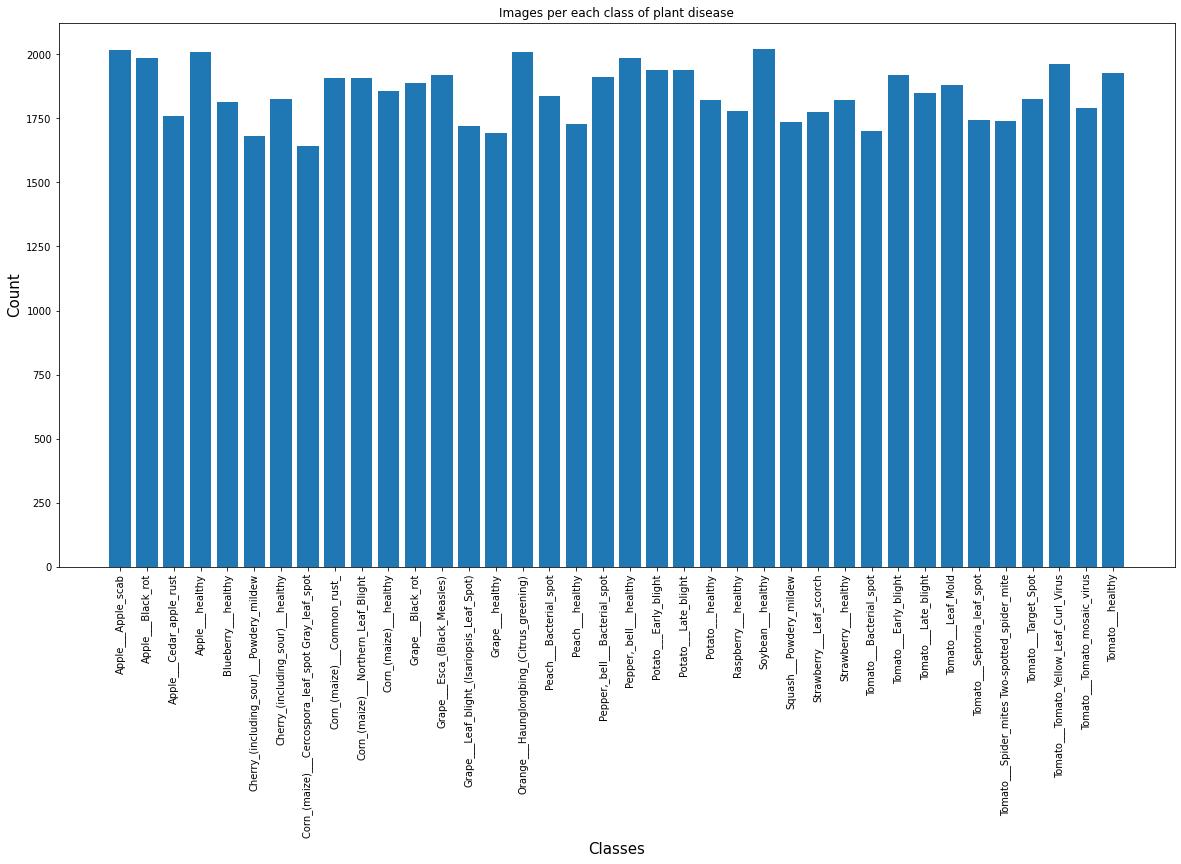

In [6]:
plt.figure(figsize=(20,10))
plt.bar(d_name, d_cnt)
plt.xlabel("Classes", fontsize = 15)
plt.ylabel("Count", fontsize = 15)
plt.xticks(np.arange(38), d_name, rotation=90)
plt.title('Images per each class of plant disease')

In [7]:
print("Image available for training ", sum(d_cnt))

Image available for training  70295


# Preparing Dataset

In [3]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)


Found 70295 files belonging to 38 classes.


In [4]:
valid_ds = tf.keras.preprocessing.image_dataset_from_directory(
    valid_dir,
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 6585 files belonging to 38 classes.


In [5]:
def get_dataset_partitions_tf(ds, val_split=0.8, test_split=0.2, shuffle=True, shuffle_size=10000):
    assert (test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    val_size = int(val_split*ds_size)
    val_ds = ds.take(val_size)
    test_ds = ds.skip(val_size)
    
    return val_ds, test_ds

In [6]:
valid_ds, test_ds = get_dataset_partitions_tf(valid_ds)

In [13]:
print("Train ds: ",len(train_ds)*BATCH_SIZE)
print("Validation ds: ",len(valid_ds)*BATCH_SIZE)
print("Test ds: ",len(test_ds)*BATCH_SIZE)

Train ds:  70300
Validation ds:  5200
Test ds:  1400


In [7]:
class_names = train_ds.class_names
class_names

['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy',
 'Blueberry___healthy',
 'Cherry_(including_sour)___Powdery_mildew',
 'Cherry_(including_sour)___healthy',
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn_(maize)___Common_rust_',
 'Corn_(maize)___Northern_Leaf_Blight',
 'Corn_(maize)___healthy',
 'Grape___Black_rot',
 'Grape___Esca_(Black_Measles)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___healthy',
 'Orange___Haunglongbing_(Citrus_greening)',
 'Peach___Bacterial_spot',
 'Peach___healthy',
 'Pepper,_bell___Bacterial_spot',
 'Pepper,_bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Raspberry___healthy',
 'Soybean___healthy',
 'Squash___Powdery_mildew',
 'Strawberry___Leaf_scorch',
 'Strawberry___healthy',
 'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_

In [15]:
for image_batch, labels_batch in train_ds.take(1):
    print(len(image_batch))
    print(image_batch.shape)
    print(labels_batch.numpy()) #lable indexes (0-38) 

100
(100, 256, 256, 3)
[12 30  0 33  6  0 36 12  3 15  6 15  4 17 29 33 25 14 32 37  5 26  8 29
 10 31 37 31 25 10  1  8 19 35 36 17  8  8 24  8 29 32 21 16 27 10 24  2
 20 21 34 33 19 12  7 15  7 17 17  9 15 23 10 37 28 26 24  8 23  8 36 31
 36 29  0 35 36 36 27  1 30 26 11 19 21  7 19 29 19 35 29 33 20 32 14 33
 15 19 19 21]


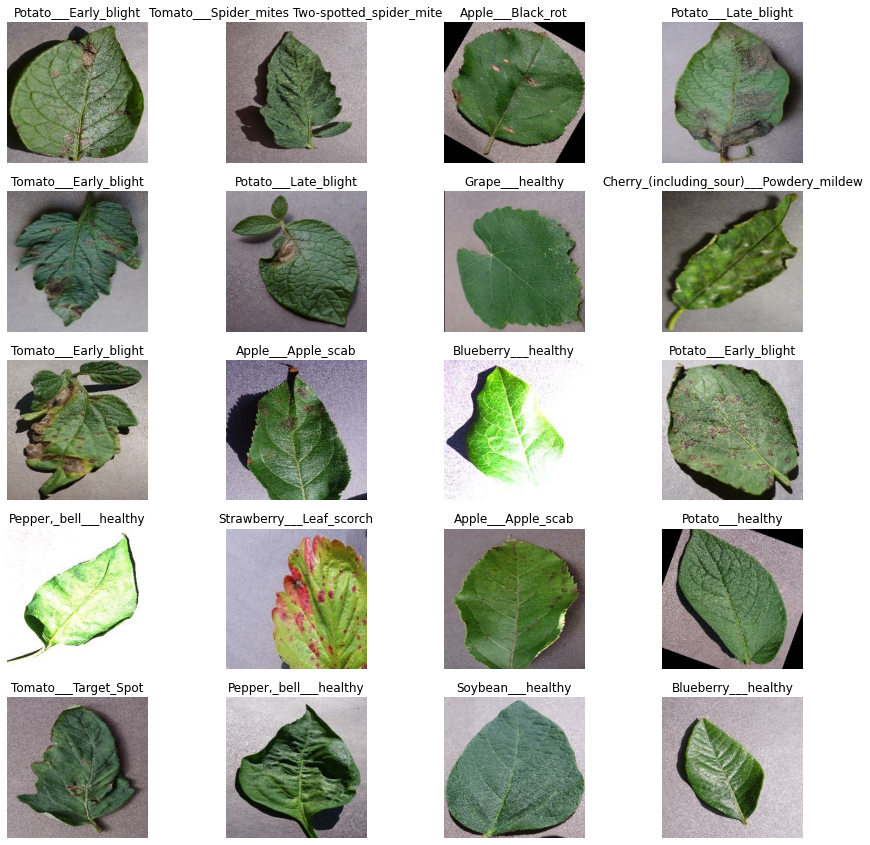

In [16]:
# print 16 images from 1 batch
plt.figure(figsize=(15, 15))
for image_batch, labels_batch in train_ds.take(1):
    for i in range(20):
        ax = plt.subplot(5, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

**Cache, Shuffle, and Prefetch the Dataset**

In [ ]:
# commented as it over-eats ram
# train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
# valid_ds = valid_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Model Building

In [ ]:
# resize_and_rescale = tf.keras.Sequential([
#   layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
#   layers.experimental.preprocessing.Rescaling(1./255),
# ])

In [8]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 38

In [9]:
model = models.Sequential([
    layers.BatchNormalization(),
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (100, 256, 256, 3)       12        
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (100, 254, 254, 32)       896       
                                                                 
 max_pooling2d (MaxPooling2D  (100, 127, 127, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (100, 125, 125, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (100, 62, 62, 64)        0         
 2D)                                                             
                                                        

In [11]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
# Early stopping condition
# early_stopping = tf.keras.callbacks.EarlyStopping(
#     monitor="val_loss",
#     min_delta=0.0001,
#     patience=5,
#     verbose=1,
#     mode="auto",
#     baseline=None,
#     restore_best_weights=False,
# )

In [12]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data= valid_ds,
    verbose=1,
    epochs = EPOCHS
)

Epoch 1/10
703/703 [==============================] - 8105s 11s/step - loss: 0.9744 - accuracy: 0.7222 - val_loss: 0.3157 - val_accuracy: 0.9003
Epoch 2/10
703/703 [==============================] - 207s 292ms/step - loss: 0.2936 - accuracy: 0.9063 - val_loss: 0.2398 - val_accuracy: 0.9229
Epoch 3/10
703/703 [==============================] - 208s 293ms/step - loss: 0.1507 - accuracy: 0.9499 - val_loss: 0.2538 - val_accuracy: 0.9223
Epoch 4/10
703/703 [==============================] - 207s 293ms/step - loss: 0.0944 - accuracy: 0.9687 - val_loss: 0.2147 - val_accuracy: 0.9413
Epoch 5/10
703/703 [==============================] - 205s 289ms/step - loss: 0.0743 - accuracy: 0.9753 - val_loss: 0.2666 - val_accuracy: 0.9369
Epoch 6/10
703/703 [==============================] - 206s 291ms/step - loss: 0.0599 - accuracy: 0.9806 - val_loss: 0.2379 - val_accuracy: 0.9421
Epoch 7/10
703/703 [==============================] - 205s 290ms/step - loss: 0.0477 - accuracy: 0.9847 - val_loss: 0.3144 - 

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

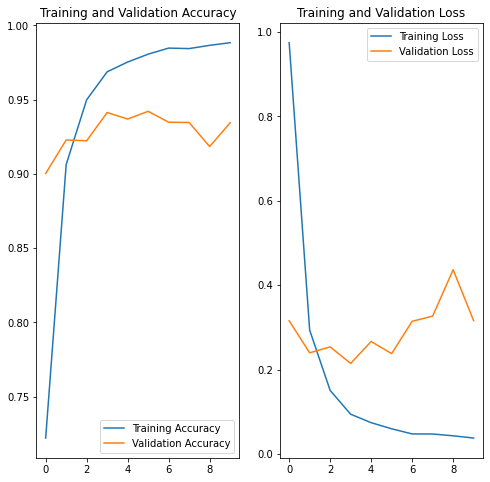

In [14]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Testing

In [15]:
scores = model.evaluate(test_ds)

14/14 [==============================] - 13s 102ms/step - loss: 0.3017 - accuracy: 0.9379


In [16]:
scores

[0.30172157287597656, 0.9378571510314941]

In [17]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

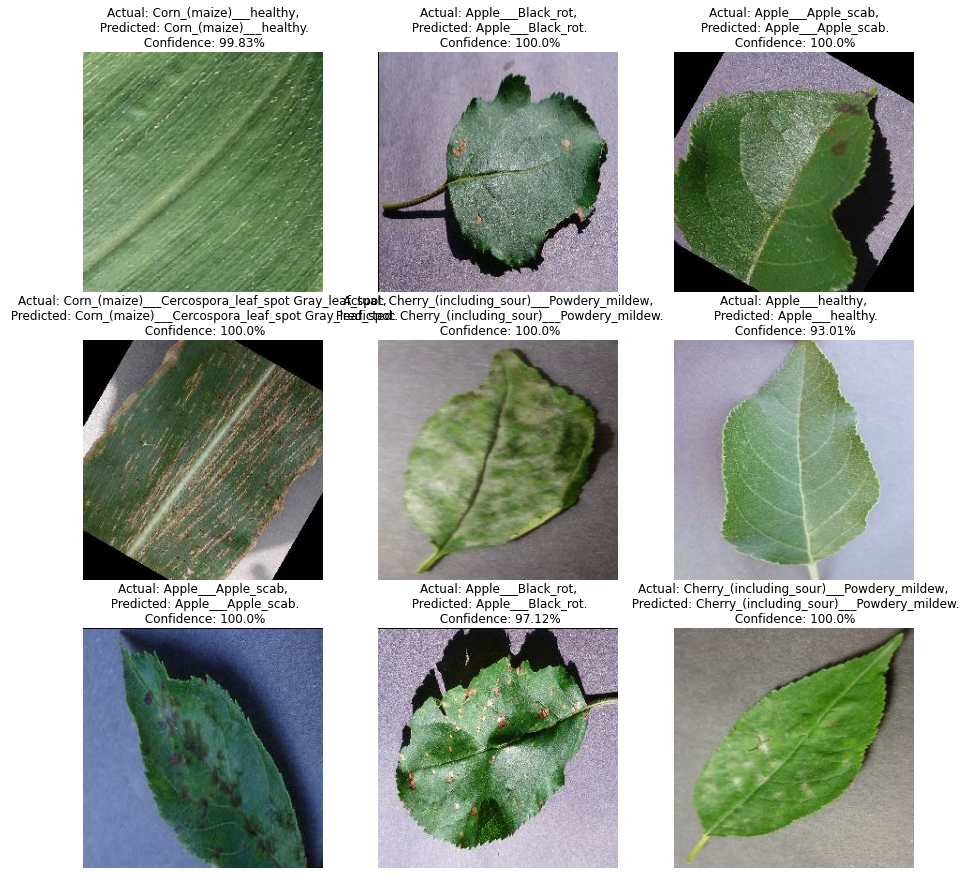

In [18]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")

**Confusion Matrix**

In [19]:
labels = []
predictions = []
for x,y in test_ds:
    labels.append(list(y.numpy()))
    predictions.append(tf.argmax(model.predict(x),1).numpy())

In [21]:
from itertools import chain
predictions = list(chain.from_iterable(predictions))
labels = list(chain.from_iterable(labels))

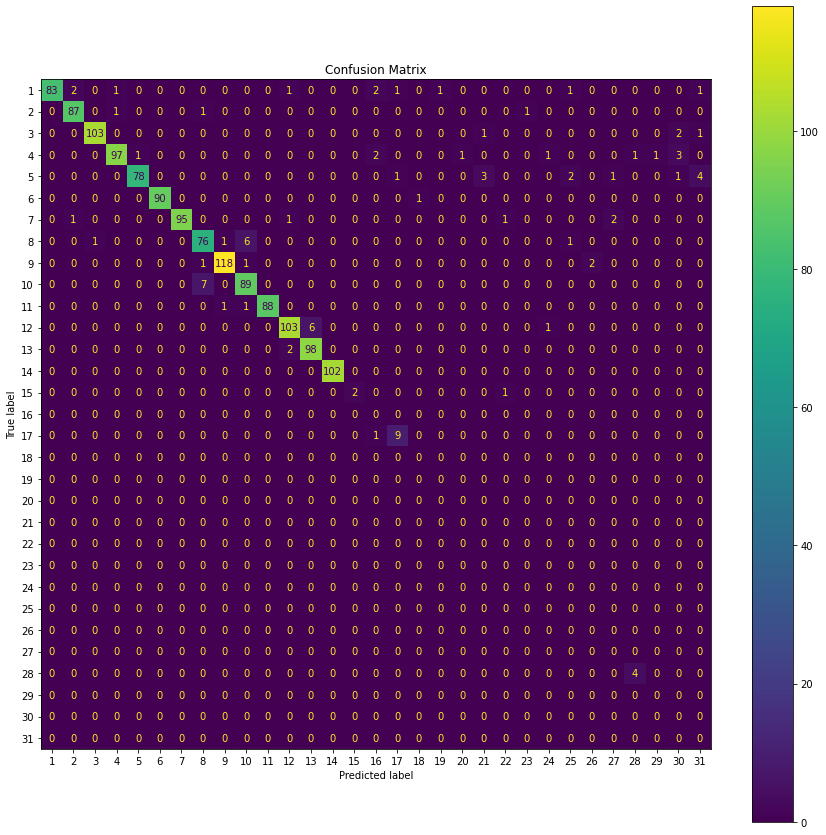

In [22]:
cm = confusion_matrix(labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=list(range(1,39)))
fig, ax = plt.subplots(figsize=(15,15))
disp.plot(ax=ax)
plt.title("Confusion Matrix")
plt.show()

In [23]:
import os
URL = "/content/drive/My Drive/Colab Notebooks/Models"
model_version="leaf_disease_2";
model.save(f"{URL}/{model_version}")

INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/Models/leaf_disease_2/assets


In [24]:
import pickle
pickle.dump(model,open('leaf_disease_model.pkl', 'wb'))

INFO:tensorflow:Assets written to: ram://291d7e3e-891c-4400-89ae-ddaf84ce0184/assets
